In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

import pyfolio
import empyrical

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


pred_linear
pred_snn
pred_lstm


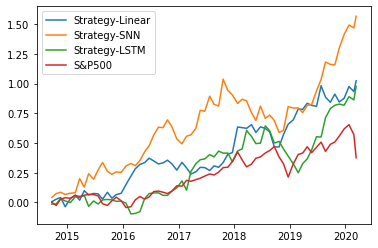

In [ ]:
index = pd.read_excel('/content/drive/My Drive/Research/Machine Learning/data/sp500.xlsx')
index = index.dropna()
index.columns = ['Date','sp500']

final_data = pd.read_csv("/content/drive/My Drive/Research/Machine Learning/data/pricing_monthly.csv")
Datelist = list(final_data.Date.unique())
results = pd.DataFrame({'Model':{},'mean':{},'Sharpe Ratio':{},'Sotino Ratio':{},'Maximum Downside':{},'Ave.P / Ave.L':{},'Alpha':{},'Beta':{},'Total Return':{}})

plt.figure()

for model in ['pred_linear','pred_snn','pred_lstm']:
  print(model)
  final_data['ym'] = 0
  for i in range(len(Datelist)):
    final_data.loc[final_data.Date == Datelist[i],'ym'] = (i+1) // 21
  base_stgy_data = final_data.sort_values(['stock','ym','Date'], ascending=False)
  base_stgy_data = base_stgy_data.drop_duplicates(['stock','ym']).reset_index(drop = True)

  ## Data PreProcessing
  base_stgy_data2 = base_stgy_data.dropna()

  ### Ranking
  base_stgy_data['rank'] = np.ceil(base_stgy_data2.groupby('ym')[model].rank(pct=True).mul(10))

  ## Return Calculation
  base_stgy_data = base_stgy_data.sort_values(['stock', 'ym']) 
  base_stgy_data['rank_L'] = base_stgy_data.groupby('stock')['rank'].shift(1)
  base_stgy_data = base_stgy_data.dropna()


  base_stgy_data['equal_weighted_return'] = base_stgy_data.groupby(['stock', 'rank_L']).label.transform('mean')

  base_stgy_sol = base_stgy_data[['ym','rank_L','equal_weighted_return','Date']] 
  base_stgy_sol = base_stgy_sol.sort_values(['ym','rank_L'])
  base_stgy_sol = base_stgy_sol.drop_duplicates(['ym','rank_L'])

  df = base_stgy_sol.pivot(index='Date', columns='rank_L', values='equal_weighted_return')
  df['10-1'] = df[10]-df[1]
  df = pd.merge(df,index, on=['Date'])
  df['market_rate'] = df.sp500 / df.sp500.shift(1) - 1
  df = df.dropna().reset_index(drop = True)
  df.index = [datetime.strptime(x, '%Y-%m-%d') for x in df.Date]

  mkt_account = [1]
  stg_account = [1]

  for i in df['market_rate']:
    mkt_account.append(mkt_account[-1]*(1+i))
  cmu_mkt_return = [x-1 for x in mkt_account]

  for i in df['10-1']:
    stg_account.append(stg_account[-1]*(1+i))
  cmu_stg_return = [x-1 for x in stg_account]

  #plt.plot()
  #plt.plot(df.index, cmu_mkt_return[1:])
  plt.plot(df.index, cmu_stg_return[1:])
  #plt.legend(['Strategy-'+model[5:]])
  #plt.savefig('/content/drive/My Drive/Research/Machine Learning/figure/'+model+'.pdf')

  #plt.show()

  bt_returns = df['10-1']
  benchmark_rets = df['market_rate']
  port_mean = empyrical.annual_return(bt_returns, period='monthly')
  port_std = empyrical.annual_volatility(bt_returns, period='monthly')
  port_sharpe = empyrical.sharpe_ratio(bt_returns, period='monthly')

  port_dd = empyrical.downside_risk(bt_returns)
  port_sortino = empyrical.sortino_ratio(bt_returns, period='monthly')
  port_sdr = port_sortino / (np.sqrt(2))

  port_mmd = empyrical.max_drawdown(bt_returns)
  port_tail_ratio = empyrical.tail_ratio(bt_returns)
  alpha, beta = empyrical.alpha_beta(bt_returns, benchmark_rets, period='monthly')

  port_ret_greater = np.sum(bt_returns>0) / len(bt_returns)    
  port_ret_pl = np.abs(np.sum(bt_returns[bt_returns>0]) / np.sum(bt_returns[bt_returns<0]))

  results.loc[len(results)] = [model,port_mean,port_sharpe,port_sortino,port_mmd,port_ret_pl,alpha,beta,stg_account[-1]-1]

plt.plot(df.index, cmu_mkt_return[1:])
plt.legend(['Strategy-Linear','Strategy-SNN','Strategy-LSTM','S&P500'])
plt.savefig('/content/drive/My Drive/Research/Machine Learning/figure/cmu_curve.pdf')

In [ ]:
plt.savefig('/content/drive/My Drive/Research/Machine Learning/figure/cmu_curve.pdf')

<Figure size 432x288 with 0 Axes>

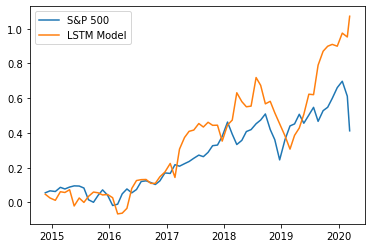

In [ ]:
mkt_account = [1]
stg_account = [1]

for i in df['market_rate']:
  mkt_account.append(mkt_account[-1]*(1+i))
cmu_mkt_return = [x-1 for x in mkt_account]

for i in df['10-1']:
  stg_account.append(stg_account[-1]*(1+i))
cmu_stg_return = [x-1 for x in stg_account]

plt.plot()
plt.plot(df.index, cmu_mkt_return[1:])
plt.plot(df.index, cmu_stg_return[1:])
plt.legend(['S&P 500','LSTM Model'])
plt.savefig('/content/drive/My Drive/Research/Machine Learning/figure/lstm.pdf')

plt.show()

In [ ]:
def state_normalisation(data):
    data_nor = (data - data.mean()) / data.std()
    return np.array(data_nor)

def downside_deviation(data):
    data = data.copy()
    data[data>0] = 0
    return np.std(data)

def max_drawdown(data):
    
    xs = np.array(data)
    i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
    
    if len(xs[:i])<=0:
        mdd = 0
        return mdd 
    
    j = np.argmax(xs[:i]) # start of period
    mdd = np.abs(xs[j] - xs[i]) / xs[j]
    return mdd 

In [ ]:
bt_returns = df['market_rate']
benchmark_rets = df['market_rate']

In [ ]:
import empyrical
import pyfolio as pf

port_mean = empyrical.annual_return(bt_returns, period='monthly')
port_std = empyrical.annual_volatility(bt_returns, period='monthly')
port_sharpe = empyrical.sharpe_ratio(bt_returns, period='monthly')

port_dd = empyrical.downside_risk(bt_returns)
port_sortino = empyrical.sortino_ratio(bt_returns, period='monthly')
port_sdr = port_sortino / (np.sqrt(2))

port_mmd = empyrical.max_drawdown(bt_returns)
port_tail_ratio = empyrical.tail_ratio(bt_returns)
alpha, beta = empyrical.alpha_beta(bt_returns, benchmark_rets, period='monthly')

port_ret_greater = np.sum(bt_returns>0) / len(bt_returns)    
port_ret_pl = np.abs(np.sum(bt_returns[bt_returns>0]) / np.sum(bt_returns[bt_returns<0]))

print('mean:', port_mean, 'std:', port_std, 'sharpe:', port_sharpe)
print('Market alpha:', alpha, 'Market beta:', beta)
print('Downside:', port_dd, 'sortino:', port_sortino, 'Symmetric Sharpe Ratio:', port_sdr)
print('Maximum DD:', port_mmd)
print('Tail ratio:', port_tail_ratio, "Kurtosis: ", stats.kurtosis(bt_returns),'Skew:', stats.skew(bt_returns))
print('max monthly gain:', np.max(bt_returns), 'max mothly loss:', np.min(bt_returns))
print('% of + Ret:', port_ret_greater)
print('Ave.P / Ave.L', port_ret_pl)

print()
print('Final wealth', stg_account[-1], 'multiplier:', stg_account[-1]/stg_account[0])
print()
#print('cost paid:', np.sum(port_all['cost']))

mean: 0.058823924069222766 std: 0.13039043152747767 sharpe: 0.5047571798834145
Market alpha: 0.0 Market beta: 1.0
Downside: 0.4253751461335462 sortino: 0.7090318820618422 Symmetric Sharpe Ratio: 0.501361251883389
Maximum DD: -0.1751221127294201
Tail ratio: 0.9805050420688664 Kurtosis:  1.2289662582607095 Skew: -0.8201249550591491
max monthly gain: 0.09339904494707496 max mothly loss: -0.1236585779087721
% of + Ret: 0.6417910447761194
Ave.P / Ave.L 1.4560620401495297

Final wealth 1.9758128767271352 multiplier: 1.9758128767271352



In [ ]:
results = pd.DataFrame({'Model':{},'mean':{},'Sharpe Ratio':{},'Sotino Ratio':{},'Maximum Downside':{},'Ave.P / Ave.L':{},'Alpha':{},'Beta':{},'Total Return':{}})
results

,Model,mean,Sharpe Ratio,Sotino Ratio,Maximum Downside,Ave.P / Ave.L,Alpha,Beta,Total Return


In [ ]:
results.loc[len(results)] = ['Index',port_mean,port_sharpe,port_sortino,port_mmd,port_ret_pl,alpha,beta,mkt_account[-1]-1]
results

,Model,mean,Sharpe Ratio,Sotino Ratio,Maximum Downside,Ave.P / Ave.L,Alpha,Beta,Total Return
0,pred_linear,0.134455,0.952743,1.833723,-0.113341,2.034436,0.145372,0.003983,1.022537
1,pred_snn,0.183826,1.140678,2.381031,-0.220239,2.308177,0.215148,-0.216268,1.565606
2,pred_lstm,0.129716,0.831530,1.563240,-0.239739,1.921396,0.159539,-0.205931,0.975813
3,Index,0.058824,0.504757,0.709032,-0.175122,1.456062,0.000000,1.000000,0.375939


In [ ]:
results.to_excel('/content/drive/My Drive/Research/Machine Learning/data/port_results.xlsx')